In [1]:
#操作方法
#実行：Ctrl＋Enter
# コメントアウト：Ctrl＋バックスラッシュ（/）

In [2]:
import csv
import numpy as np
from pylab import rcParams
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn import linear_model
import pandas as pd
import datetime as dt
import math
import sys
import matplotlib.pyplot as plt
from matplotlib import animation

import seaborn as sns


In [4]:
#read a file
#インデックスをTIMESTANPに設定し，時系列データとして読み込む(index_col='TIMESTAMP', parse_dates=True)
df01 = pd.read_csv('logger1_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df02 = pd.read_csv('logger2_2018-03-13_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df03 = pd.read_csv('logger3_2018-03-20_2018-12-16_every1min_withoutRainfall_WL_Velocity.csv', index_col='TIMESTAMP', parse_dates=True)
df04 = pd.read_csv('Precipitation_WL_Velocity201801to201812_every_1min.csv', index_col='TIMESTAMP', parse_dates=True)
# print(df01,df02,df03,df04)

In [5]:
df_all = pd.concat([df01, df02, df03, df04], axis=1,sort=False)

# #NaNデータを削除
# df_all = df_all.dropna(how='any')


#重複した列を削除(WLなど)
df_all = df_all.loc[:,~df_all.columns.duplicated()]

#Load_Avgの差分をとる
df_all['Load_Avg_difference'] = df_all['Load_Avg'].diff()

In [6]:
#縦横補正する
h, hp, l = 1, 1, 1


for i in range(1,10):
    df_all['Rhv_right_Tot({})'.format(i)] = (df_all['VR_Tot({})'.format(i)]/h)/(df_all['R_Tot({})'.format(i)]/l)
    df_all['Rhv_left_Tot({})'.format(i)] = (df_all['VL_Tot({})'.format(i)]/h)/(df_all['L_Tot({})'.format(i)]/l)
    
    df_all['Corrected_with_right_Tot({})'.format(i)] = df_all['Rhv_right_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]
    df_all['Corrected_with_left_Tot({})'.format(i)] = df_all['Rhv_left_Tot({})'.format(i)]*h/hp*df_all['C_Tot({})'.format(i)]


In [7]:
df_all.head()
df_all.columns[1]

'RECORD'

In [8]:
#name[1]にはスロット１のデータ、name[2]には、スロット２のデータ、name[3]に、、、が入っている
name = [0]*9
for j in range(1,10):
    name[j-1] = [i for i in df_all.columns if '({})'.format(j) in i]

In [9]:
#（スロット１のデータ）−（スロット２のデータ）、（スロット２のデータ）－（スロット３のデータ）、、、としていき、
#粒径ごとのデータに分類する
df_dia = [0]*9
for i in range(1,9):
    df_dia[i-1] = df_all[name[i-1]] - df_all[name[i]].values

#全てのデータを繋げる
df_dia_all = pd.DataFrame()
for i in range(1,9):
    df_dia_all = pd.concat([df_dia_all, df_dia[i-1]], axis=1 )

In [10]:
df_dia_all['Load_Avg'] = df_all['Load_Avg']
df_dia_all['Load_Avg_difference'] = df_all['Load_Avg_difference']

In [11]:
#df_all_1.columnsを全部表示させるようにする
pd.options.display.max_seq_items = 200

print(df_dia_all.columns)

#pd.options.display.max_seq_itemsを元にもどす(初期値が２０だった)
pd.options.display.max_seq_items = 20

Index(['hp_Tot(1)', 'R_Tot(1)', 'RC_Tot(1)', 'C_Tot(1)', 'LC_Tot(1)',
       'L_Tot(1)', 'VR_Tot(1)', 'VL_Tot(1)', 'VC_Tot(1)', 'T75_Tot(1)',
       'Plate_Tot(1)', 'Rhv_right_Tot(1)', 'Rhv_left_Tot(1)',
       'Corrected_with_right_Tot(1)', 'Corrected_with_left_Tot(1)',
       'hp_Tot(2)', 'R_Tot(2)', 'RC_Tot(2)', 'C_Tot(2)', 'LC_Tot(2)',
       'L_Tot(2)', 'VR_Tot(2)', 'VL_Tot(2)', 'VC_Tot(2)', 'T75_Tot(2)',
       'Plate_Tot(2)', 'Rhv_right_Tot(2)', 'Rhv_left_Tot(2)',
       'Corrected_with_right_Tot(2)', 'Corrected_with_left_Tot(2)',
       'hp_Tot(3)', 'R_Tot(3)', 'RC_Tot(3)', 'C_Tot(3)', 'LC_Tot(3)',
       'L_Tot(3)', 'VR_Tot(3)', 'VL_Tot(3)', 'VC_Tot(3)', 'T75_Tot(3)',
       'Plate_Tot(3)', 'Rhv_right_Tot(3)', 'Rhv_left_Tot(3)',
       'Corrected_with_right_Tot(3)', 'Corrected_with_left_Tot(3)',
       'hp_Tot(4)', 'R_Tot(4)', 'RC_Tot(4)', 'C_Tot(4)', 'LC_Tot(4)',
       'L_Tot(4)', 'VR_Tot(4)', 'VL_Tot(4)', 'VC_Tot(4)', 'T75_Tot(4)',
       'Plate_Tot(4)', 'Rhv_right_Tot(4)',

In [12]:
#event No. 1: 2018年4月15日 0:00－16日 0:00  24h
#event No. 2: 2018年4月24日18:00－25日18:00  24h
#event No. 3: 2018年6月28日 6:00－28日18:00  12h
#event No. 4: 2018年9月 8日 0:00－16日12:00  372h
#event No. 5: 2018年9月30日21:00－10月1日3:00 6h

df_event_no1 = df_dia_all['2018-04-15 0:00' : '2018-04-16 0:00']
df_event_no2 = df_dia_all['2018-04-24 18:00' : '2018-04-25 18:00']
df_event_no3 = df_dia_all['2018-06-28 6:00' : '2018-06-28 18:00']
df_event_no4 = df_dia_all['2018-09-08 0:00' : '2018-09-16 12:00']
df_event_no5 = df_dia_all['2018-09-30 21:00' : '2018-10-1 6:00']

df_event_no3 = df_event_no3[df_event_no3['Load_Avg'] < 1400]
df_event_no4 = df_event_no4[df_event_no4['Load_Avg'] < 1400]

# df_event_no2 = df_event_no2['2018-04-25 7:00' : '2018-04-25 11:00']
df_event_no4 = df_event_no4['2018-09-08 0:00' : '2018-09-08 8:00']
df_event_no2 = df_event_no2['2018-04-25 6:30' : '2018-04-25 11:00']
df_event_no3 = df_event_no3['2018-06-28 9:30' : '2018-06-28 11:20']


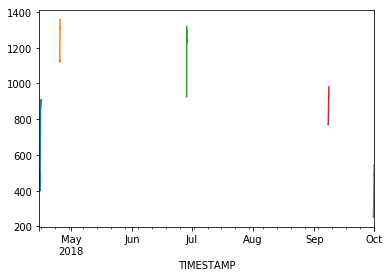

In [25]:
plt.figure()
df_event_no1['Load_Avg'].plot()
df_event_no2['Load_Avg'].plot()
df_event_no3['Load_Avg'].plot()
df_event_no4['Load_Avg'].plot()
df_event_no5['Load_Avg'].plot()
# df_event_no4['VR_Tot(3)'].plot()
# df_event_no4['R_Tot(3)'].plot()
# df_event_no4['Rhv_right'].plot()


In [14]:
def mean_every_xmin(df, x):
    """
    x：the value you wanna take an average of
    """
#     df_mean = df.asfreq('{}T'.format(x))
    df_mean = df.resample('{}T'.format(x)).sum()
    return df_mean
        
df_event_no1_10min = mean_every_xmin(df_event_no1, 10)
df_event_no1_20min = mean_every_xmin(df_event_no1, 20)
df_event_no1_30min = mean_every_xmin(df_event_no1, 30)
df_event_no1_40min = mean_every_xmin(df_event_no1, 40)
df_event_no1_50min = mean_every_xmin(df_event_no1, 50)
df_event_no1_60min = mean_every_xmin(df_event_no1, 60)
df_event_no1_70min = mean_every_xmin(df_event_no1, 70)
df_event_no1_80min = mean_every_xmin(df_event_no1, 80)
df_event_no1_90min = mean_every_xmin(df_event_no1, 90)

df_event_no2_10min = mean_every_xmin(df_event_no2, 10)
df_event_no2_20min = mean_every_xmin(df_event_no2, 20)
df_event_no2_30min = mean_every_xmin(df_event_no2, 30)
df_event_no2_40min = mean_every_xmin(df_event_no2, 40)
df_event_no2_50min = mean_every_xmin(df_event_no2, 50)
df_event_no2_60min = mean_every_xmin(df_event_no2, 60)
df_event_no2_70min = mean_every_xmin(df_event_no2, 70)
df_event_no2_80min = mean_every_xmin(df_event_no2, 80)
df_event_no2_90min = mean_every_xmin(df_event_no2, 90)

df_event_no3_10min = mean_every_xmin(df_event_no3, 10)
df_event_no3_20min = mean_every_xmin(df_event_no3, 20)
df_event_no3_30min = mean_every_xmin(df_event_no3, 30)
df_event_no3_40min = mean_every_xmin(df_event_no3, 40)
df_event_no3_50min = mean_every_xmin(df_event_no3, 50)
df_event_no3_60min = mean_every_xmin(df_event_no3, 60)
df_event_no3_70min = mean_every_xmin(df_event_no3, 70)
df_event_no3_80min = mean_every_xmin(df_event_no3, 80)
df_event_no3_90min = mean_every_xmin(df_event_no3, 90)

df_event_no4_10min = mean_every_xmin(df_event_no4, 10)
df_event_no4_20min = mean_every_xmin(df_event_no4, 20)
df_event_no4_30min = mean_every_xmin(df_event_no4, 30)
df_event_no4_40min = mean_every_xmin(df_event_no4, 40)
df_event_no4_50min = mean_every_xmin(df_event_no4, 50)
df_event_no4_60min = mean_every_xmin(df_event_no4, 60)
df_event_no4_70min = mean_every_xmin(df_event_no4, 70)
df_event_no4_80min = mean_every_xmin(df_event_no4, 80)
df_event_no4_90min = mean_every_xmin(df_event_no4, 90)
df_event_no4_180min = mean_every_xmin(df_event_no4, 180)
df_event_no4_360min = mean_every_xmin(df_event_no4, 360)
df_event_no4_720min = mean_every_xmin(df_event_no4, 720)


df_event_no5_10min = mean_every_xmin(df_event_no5, 10)
df_event_no5_20min = mean_every_xmin(df_event_no5, 20)
df_event_no5_30min = mean_every_xmin(df_event_no5, 30)
df_event_no5_40min = mean_every_xmin(df_event_no5, 40)
df_event_no5_50min = mean_every_xmin(df_event_no5, 50)
df_event_no5_60min = mean_every_xmin(df_event_no5, 60)
df_event_no5_70min = mean_every_xmin(df_event_no5, 70)
df_event_no5_80min = mean_every_xmin(df_event_no5, 80)
df_event_no5_90min = mean_every_xmin(df_event_no5, 90)

In [15]:
def scatter_graph_in_df(df, x_name='Load_Avg_difference', y_name='hp_Tot(4)', x_range=(-500,500), y_range=(-100,500)):
    '''
    df :　DetaFrame
    x_name：ｘ軸に用いるパラメータの名前(str)
    y_name：ｙ軸に用いるパラメータの名前(str)
    Index(['Unnamed: 0', 'RECORD', 'Bat_Avg', 'Pit_WL_Avg', 'L_UR_Avg', 'L_UL_Avg',
       'L_DR_Avg', 'L_DL_Avg', 'Load_Avg', 'WL_FMR_Avg', 'vel_P_Tot',
       'turb1000_Avg', 'turb4000_Avg', 'DiffVolt_Avg', 'hp_Tot(1)',
       'hp_Tot(2)', 'hp_Tot(3)', 'hp_Tot(4)', 'hp_Tot(5)', 'hp_Tot(6)',
       'hp_Tot(7)', 'hp_Tot(8)', 'hp_Tot(9)', 'hp_Tot(10)', 'outC_R_Avg',
       'R_Tot(1)', 'R_Tot(2)', 'R_Tot(3)', 'R_Tot(4)', 'R_Tot(5)', 'R_Tot(6)',
       'R_Tot(7)', 'R_Tot(8)', 'R_Tot(9)', 'R_Tot(10)', 'outC_RC_Avg',
       'RC_Tot(1)', 'RC_Tot(2)', 'RC_Tot(3)', 'RC_Tot(4)', 'RC_Tot(5)',
       'RC_Tot(6)', 'RC_Tot(7)', 'RC_Tot(8)', 'RC_Tot(9)', 'RC_Tot(10)',
       'outC_C_Avg', 'C_Tot(1)', 'C_Tot(2)', 'C_Tot(3)', 'C_Tot(4)',
       'C_Tot(5)', 'C_Tot(6)', 'C_Tot(7)', 'C_Tot(8)', 'C_Tot(9)', 'C_Tot(10)',
       'outC_LC_Avg', 'LC_Tot(1)', 'LC_Tot(2)', 'LC_Tot(3)', 'LC_Tot(4)',
       'LC_Tot(5)', 'LC_Tot(6)', 'LC_Tot(7)', 'LC_Tot(8)', 'LC_Tot(9)',
       'LC_Tot(10)', 'outC_L_Avg', 'L_Tot(1)', 'L_Tot(2)', 'L_Tot(3)',
       'L_Tot(4)', 'L_Tot(5)', 'L_Tot(6)', 'L_Tot(7)', 'L_Tot(8)', 'L_Tot(9)',
       'L_Tot(10)', 'outC_VR_Avg', 'VR_Tot(1)', 'VR_Tot(2)', 'VR_Tot(3)',
       'VR_Tot(4)', 'VR_Tot(5)', 'VR_Tot(6)', 'VR_Tot(7)', 'VR_Tot(8)',
       'VR_Tot(9)', 'VR_Tot(10)', 'outC_VL_Avg', 'VL_Tot(1)', 'VL_Tot(2)',
       'VL_Tot(3)', 'VL_Tot(4)', 'VL_Tot(5)', 'VL_Tot(6)', 'VL_Tot(7)',
       'VL_Tot(8)', 'VL_Tot(9)', 'VL_Tot(10)', 'outC_VC_Avg', 'VC_Tot(1)',
       'VC_Tot(2)', 'VC_Tot(3)', 'VC_Tot(4)', 'VC_Tot(5)', 'VC_Tot(6)',
       'VC_Tot(7)', 'VC_Tot(8)', 'VC_Tot(9)', 'VC_Tot(10)', 'outC_T75_Avg',
       'T75_Tot(1)', 'T75_Tot(2)', 'T75_Tot(3)', 'T75_Tot(4)', 'T75_Tot(5)',
       'T75_Tot(6)', 'T75_Tot(7)', 'T75_Tot(8)', 'T75_Tot(9)', 'T75_Tot(10)',
       'outC_Plate_Avg', 'Plate_Tot(1)', 'Plate_Tot(2)', 'Plate_Tot(3)',
       'Plate_Tot(4)', 'Plate_Tot(5)', 'Plate_Tot(6)', 'Plate_Tot(7)',
       'Plate_Tot(8)', 'Plate_Tot(9)', 'Plate_Tot(10)', 'Vib_Avg',
       'Precipitation(mm)', 'Velocity(m/s)', 'WaterLevel(cm)'],
      dtype='object')
    '''
    # 「散布図行列」を作成する。散布図行列を利用すれば、データセットの特徴量のペアに対す
    # る相関関係を1 つの平面上で可視化可能
    # Notebook出力には次の１行が必要
    a, b = x_range
    c, d = y_range
#     %matplotlib inline
    # Plot the data you select
    plt.figure(figsize=(8, 6))

    plt.scatter(df[x_name], df[y_name])
    plt.xlim(a, b)
    plt.ylim(c, d)
    
    plt.show()
 

In [16]:
#最小2乗法
def linear_regression(df_X, df_Y, color='r'):

    """
    X:input of x ax(example:x_cols)
    Y:input of y ax(example:x_cols)
    """
    #fit_intercept	False に設定すると切片を求める計算を含めない。
    #目的変数が原点を必ず通る性質のデータを扱うときに利用。 (デフォルト値: True)
    clf = linear_model.LinearRegression(fit_intercept=False)
    X = df_X.values.reshape(-1, 1)
    Y = df_Y.values.reshape(-1, 1)
    clf.fit(X,Y)
#     #傾きをレジェンド表記
#     print(clf.intercept_)
##　レジェンドに切片を含める
#     label_slope= "slope:" + str(round(clf.coef_.flatten()[0],1)) + \
#                             "\n" + "intercept:" + str(round(clf.intercept_,1)) + \
#                             "\n" + "R^2:" + str(round(clf.score(X, Y).flatten()[0],1))
##　レジェンドに切片を含めない（切片０だから）    
#     print("R^2=",clf.score(X, Y))
    label_slope= "slope:" + str(round(clf.coef_.flatten()[0],1)) + \
                            "\n" + "R^2:" + str(round(clf.score(X, Y),1))
    
#     print("切片：",clf.intercept_)
#     plt.scatter(X, Y)
    # 回帰直線
    plt.plot(X, clf.predict(X), label=label_slope, c=color)
    plt.legend()

In [17]:
# y_cols = 'Corrected_with_right_Tot(2)'
# y_cols = 'hp_Tot(5)'
y_cols = 'VR_Tot(3)'
# y_cols = 'C_Tot(3)'
x_cols = 'Load_Avg_difference'

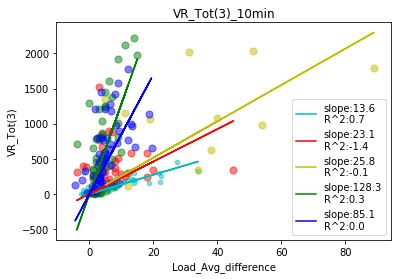

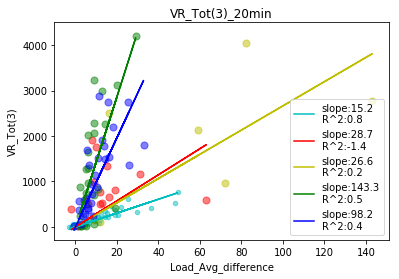

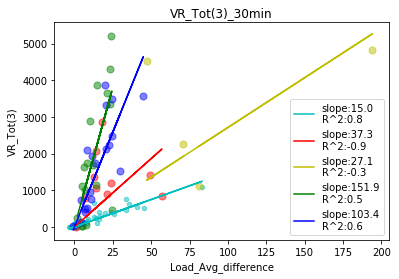

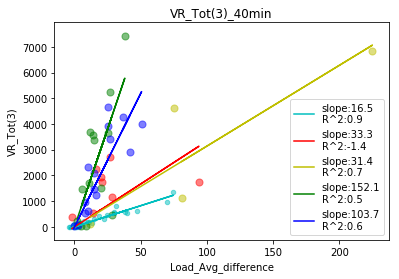

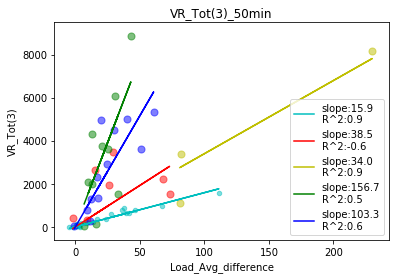

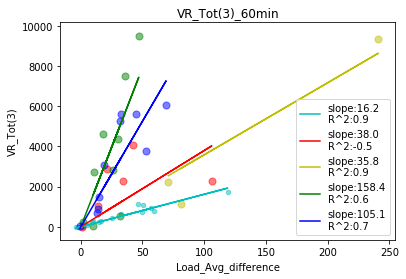

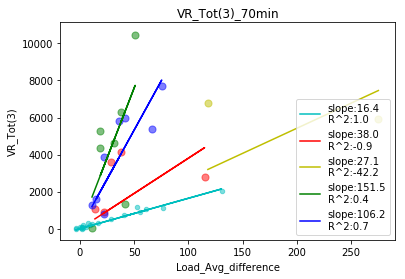

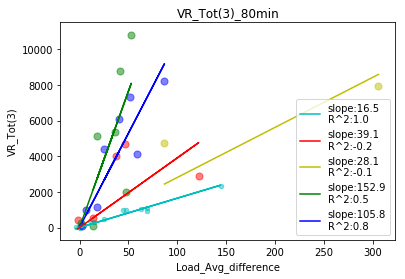

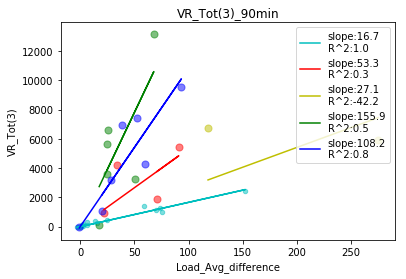

In [18]:
list_of_color = ['c','r','y','g','b']
for i in range(1,10):
    ax = eval('df_event_no1_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols, alpha=0.5,c=list_of_color[0])
    linear_regression(eval('df_event_no1_{}min[x_cols]'.format(i*10)),eval('df_event_no1_{}min[y_cols]'.format(i*10)),color=list_of_color[0])
    plt.title('{0}_{1}min'.format(y_cols,i*10))

    eval('df_event_no2_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                         c=list_of_color[1], s=50, alpha=0.5, ax=ax)
    linear_regression(eval('df_event_no2_{}min[x_cols]'.format(i*10)),eval('df_event_no2_{}min[y_cols]'.format(i*10)),color=list_of_color[1])

    eval('df_event_no3_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                         c=list_of_color[2], s=50, alpha=0.5, ax=ax)
    linear_regression(eval('df_event_no3_{}min[x_cols]'.format(i*10)),eval('df_event_no3_{}min[y_cols]'.format(i*10)),color=list_of_color[2])

    eval('df_event_no4_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                         c=list_of_color[3], s=50, alpha=0.5, ax=ax)
    linear_regression(eval('df_event_no4_{}min[x_cols]'.format(i*10)),eval('df_event_no4_{}min[y_cols]'.format(i*10)),color=list_of_color[3])

    eval('df_event_no5_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                         c=list_of_color[4], s=50, alpha=0.5, ax=ax)
    linear_regression(eval('df_event_no5_{}min[x_cols]'.format(i*10)),eval('df_event_no5_{}min[y_cols]'.format(i*10)),color=list_of_color[4])

#     plt.savefig('{0}_{1}min'.format(y_cols,i*10))
#     plt.close()

In [19]:
def make_all_scatter_graphs():
    #x_cols'Load_Avg_difference'に対し、y_colsを１つずつ全て対応させてグラフを書く
    x_cols = 'Load_Avg_difference'
    for y_cols in df_dia_all.columns:

    #イベント１～５までのデータをプロットする。def linear_regressionで１つ１つのイベントに対し、最小2乗法を適応
        list_of_color = ['c','r','y','g','b']
        for i in range(1,10):
            ax = eval('df_event_no1_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols, alpha=0.5,c=list_of_color[0])
            linear_regression(eval('df_event_no1_{}min[x_cols]'.format(i*10)),eval('df_event_no1_{}min[y_cols]'.format(i*10)),color=list_of_color[0])
            plt.title('{0}_{1}min'.format(y_cols,i*10))

            eval('df_event_no2_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                             c=list_of_color[1], s=50, alpha=0.5, ax=ax)
            linear_regression(eval('df_event_no2_{}min[x_cols]'.format(i*10)),eval('df_event_no2_{}min[y_cols]'.format(i*10)),color=list_of_color[1])

            eval('df_event_no3_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                             c=list_of_color[2], s=50, alpha=0.5, ax=ax)
            linear_regression(eval('df_event_no3_{}min[x_cols]'.format(i*10)),eval('df_event_no3_{}min[y_cols]'.format(i*10)),color=list_of_color[2])

            eval('df_event_no4_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                             c=list_of_color[3], s=50, alpha=0.5, ax=ax)
            linear_regression(eval('df_event_no4_{}min[x_cols]'.format(i*10)),eval('df_event_no4_{}min[y_cols]'.format(i*10)),color=list_of_color[3])

            eval('df_event_no5_{}min'.format(i*10)).plot.scatter(x=x_cols, y=y_cols,
                             c=list_of_color[4], s=50, alpha=0.5, ax=ax)
            linear_regression(eval('df_event_no5_{}min[x_cols]'.format(i*10)),eval('df_event_no5_{}min[y_cols]'.format(i*10)),color=list_of_color[4])

            plt.savefig('{0}_{1}min'.format(y_cols,i*10))
            plt.close()

#すべてのcolumnと'Load_Avg_difference'の分布図をローカルフォルダに保存する
# make_all_scatter_graphs()

In [20]:
#あとでdefにまとめる！

list_of_event_all = []
for i in range(1, 6):
    for j in range(1, 10):
        list_of_event_all.append('df_event_no{0}_{1}min'.format(i, j*10))

list_of_event_10min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_10min.append('df_event_no{0}_{1}min'.format(i, j*10))
        
list_of_event_20min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_20min.append('df_event_no{0}_{1}min'.format(i, j*10))
        
list_of_event_30min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_30min.append('df_event_no{0}_{1}min'.format(i, j*10))

list_of_event_40min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_40min.append('df_event_no{0}_{1}min'.format(i, j*10))
list_of_event_50min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_50min.append('df_event_no{0}_{1}min'.format(i, j*10))
        
list_of_event_60min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_60min.append('df_event_no{0}_{1}min'.format(i, j*10))
        
list_of_event_70min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_70min.append('df_event_no{0}_{1}min'.format(i, j*10))

list_of_event_80min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_80min.append('df_event_no{0}_{1}min'.format(i, j*10))
        
list_of_event_90min = []
for i in range(1, 6):
    for j in range(1, 2):
        list_of_event_90min.append('df_event_no{0}_{1}min'.format(i, j*10))



In [21]:
def sum_of_each_event(df, col_name='Load_Avg_difference'):
    sumall = df[col_name].sum()
    return sumall

[503.4, 218.0, 393.0, 212.0, 290.70000000000005]
[20359.0, 18095.0, 13644.0, 21507.0, 22018.0]


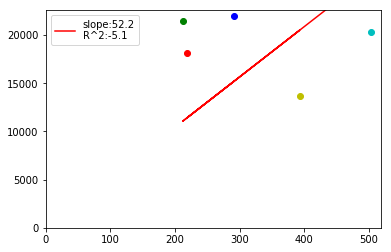

In [31]:
y_cols = 'hp_Tot(5)'
list_of_sum_pit_diff = []
for i in list_of_event_30min:
    list_of_sum_pit_diff.append(sum_of_each_event(eval(i),col_name='Load_Avg_difference'))
print(list_of_sum_pit_diff)

list_of_sum_puls = []
for i in list_of_event_30min:
    list_of_sum_puls.append(sum_of_each_event(eval(i),col_name=y_cols))
print(list_of_sum_puls)

plt.figure()
for i in range(5):
    plt.scatter(list_of_sum_pit_diff[i], list_of_sum_puls[i], c=list_of_color[i])

plt.xlim(0)
plt.ylim(0)

df_sum_pit_diff = pd.DataFrame(list_of_sum_pit_diff)
df_sum_puls = pd.DataFrame(list_of_sum_puls)
linear_regression(df_sum_pit_diff, df_sum_puls)

plt.show()